#Start with the data preprocessing:
- shape = (224,224,3)
- [Dataset](https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip)



In [1]:
# Get the data -For Google Colab only-
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2022-01-06 23:08:28--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.188.128, 108.177.125.128, 142.250.157.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.188.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  35.9MB/s    in 4.5s    

2022-01-06 23:08:33 (35.9 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [18]:
# unzip the newly downloaded data
import zipfile
zip_reference = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_reference.extractall()
zip_reference.close()

In [12]:
# initialize global vairables useful for speed 
EPOCHS = 5
SHAPE = (224, 224)

In [28]:
"""
# DEBUG CODE
import os
# walk through data
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories, {len(filenames)} images in directory: {dirpath}")
"""

'\n# DEBUG CODE\nimport os\n# walk through data\nfor dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):\n  print(f"There are {len(dirnames)} directories, {len(filenames)} images in directory: {dirpath}")\n'

In [27]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# get training and testing data
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

# get data generators
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# get images from directory
print("Training images:")
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=SHAPE,
                                               batch_size=32,
                                               class_mode="categorical")

print("Testing images:")
test_data = test_datagen.flow_from_directory(test_dir, 
                                             target_size=SHAPE,
                                             batch_size=32,
                                             class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


#Callbacks
Use this callback to upload and save to Tensorboard

In [38]:
def tensorboard_callback(dir, experiment):
  """ 
  Function that will be used as a callback in the model's
  fitting to save performance in tensorboard
  """
  import datetime

  directory = dir + "/" + experiment + "/" + datetime.datetime.now().strftime("%y%m%d-%H%M%S")
  callback = tf.keras.callbacks.TensorBoard(log_dir=directory)
  print(f"Saving logfiles to {directory}")
  return callback

#Setting up model
The model to be used is [Mobilnet_v2](https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4)

In [33]:
# functionize creating models from url
def create_url_mode(url, classes=10, shape=(224,224)):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    url (str): A TensorFlow Hub Feature Extraction URL.
    classes (int):  Number if neurons in the OUTPUT layer, equal to number of 
    terget classes. Defaukt = 10.
  """
  import tensorflow_hub as hub

  # download pretrained model and save as layer
  feature_extraction_layer = hub.KerasLayer(url, trainable=False, name="Feature_extraction_layer",
                                            input_shape=shape+(3,))
  
  # check for multivariate or single variate
  if classes == 2:
    activation = tf.keras.activations.sigmoid
  elif classes > 2:
    activation = tf.keras.activations.softmax
  else:
    raise Exception("Classes need to be greater than 1")

  # create model
  model = tf.keras.Sequential([
    # input and hidden layers
    feature_extraction_layer,
    # output layer
    tf.keras.layers.Dense(units=classes, activation=activation, name="output_layer")
  ])

  return model

In [35]:
# create mobilnet model
mobilnet_model = create_url_mode(url="https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4",
                                 classes=train_data.num_classes)

In [36]:
# validate the model creation 
mobilnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Feature_extraction_layer (K  (None, 1280)             2257984   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 2,270,794
Trainable params: 12,810
Non-trainable params: 2,257,984
_________________________________________________________________


In [37]:
# first compilation of model
mobilnet_model.compile(loss=tf.keras.losses.categorical_crossentropy,
                       optimizer=tf.keras.optimizers.Adam(),
                       metrics=["accuracy"])

In [39]:
mobilnet_history_0 = mobilnet_model.fit(train_data, epochs=EPOCHS, steps_per_epoch=len(train_data),
                                        validation_data=test_data, validation_steps=len(test_data),
                                        callbacks=[tensorboard_callback(dir="tf_hub", experiment="mobilnet_0")])

Saving logfiles to tf_hub/mobilnet_0/220107-000521
Epoch 1/5
24/24 [==============================] - 31s 806ms/step - loss: 1.9539 - accuracy: 0.3547 - val_loss: 1.2779 - val_accuracy: 0.6272
Epoch 2/5
24/24 [==============================] - 18s 754ms/step - loss: 1.0378 - accuracy: 0.6920 - val_loss: 0.8967 - val_accuracy: 0.7312
Epoch 3/5
24/24 [==============================] - 18s 779ms/step - loss: 0.7452 - accuracy: 0.7760 - val_loss: 0.7685 - val_accuracy: 0.7640
Epoch 4/5
24/24 [==============================] - 18s 772ms/step - loss: 0.5965 - accuracy: 0.8373 - val_loss: 0.6948 - val_accuracy: 0.7844
Epoch 5/5
24/24 [==============================] - 18s 770ms/step - loss: 0.4909 - accuracy: 0.8720 - val_loss: 0.6525 - val_accuracy: 0.7892


#Compare models
Compare models [resnet](https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5) and mobilnet.

In [41]:
# create resnet model
resnet_model = create_url_mode("https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5",
                               classes=train_data.num_classes)

# compile the model
resnet_model.compile(loss=tf.keras.losses.categorical_crossentropy,
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

# fit the model
resnet_history_0 = resnet_model.fit(train_data, epochs=EPOCHS, steps_per_epoch=len(train_data),
                                        validation_data=test_data, validation_steps=len(test_data),
                                        callbacks=[tensorboard_callback(dir="tf_hub", experiment="resnet_0")])

Saving logfiles to tf_hub/resnet_0/220107-001742
Epoch 1/5
24/24 [==============================] - 30s 1s/step - loss: 1.9907 - accuracy: 0.3360 - val_loss: 1.2572 - val_accuracy: 0.5992
Epoch 2/5
24/24 [==============================] - 21s 918ms/step - loss: 0.9558 - accuracy: 0.7240 - val_loss: 0.8732 - val_accuracy: 0.7272
Epoch 3/5
24/24 [==============================] - 21s 915ms/step - loss: 0.6526 - accuracy: 0.8187 - val_loss: 0.7631 - val_accuracy: 0.7572
Epoch 4/5
24/24 [==============================] - 21s 919ms/step - loss: 0.4896 - accuracy: 0.8787 - val_loss: 0.7101 - val_accuracy: 0.7668
Epoch 5/5
24/24 [==============================] - 22s 920ms/step - loss: 0.3945 - accuracy: 0.9093 - val_loss: 0.6894 - val_accuracy: 0.7792


In [48]:
def compare_histories(first_h, second_h):
  """ Compares two histories inputed """
  import matplotlib.pyplot as plt
  # get first measurments
  f_acc = first_h.history["accuracy"]
  f_loss = first_h.history["loss"]
  f_val_loss = first_h.history["val_loss"]

  # get second measurments
  s_acc = second_h.history["accuracy"]
  s_loss = second_h.history["loss"]
  s_val_loss = second_h.history["val_loss"]

  # plot measurments
  plt.figure(figsize=(10,10))
  plt.subplot(2,1,1)
  plt.plot(f_acc, label="first_acc")
  plt.plot(s_acc, label="second_acc")
  plt.legend()

  plt.figure(figsize=(10,10))
  plt.subplot(2,1,1)
  plt.plot(f_loss, label="first_acc")
  plt.plot(s_loss, label="second_acc")
  plt.legend()

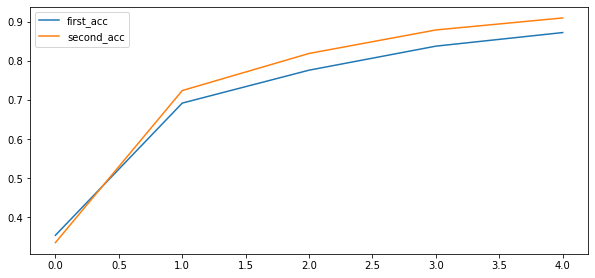

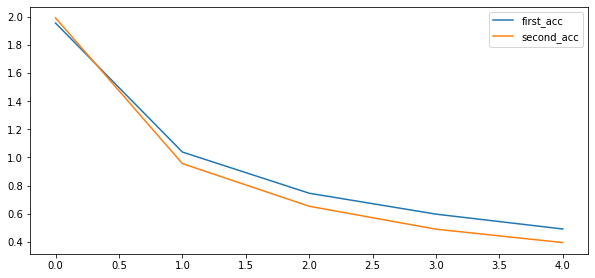

In [49]:
compare_histories(mobilnet_history_0, resnet_history_0)